# Demo - Generating Groundtruth from S2 images and FloodMaps

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

import logging
import json
from src.data.create_gt import (
    generate_water_cloud_binary_gt,
    generate_land_water_cloud_gt,
)
import pandas as pd
import numpy as np
from rasterio import features
import rasterio
import geopandas as gpd
import os
from shapely.ops import cascaded_union
from src.data.utils import filter_pols, filter_land
from typing import Optional, Dict, Tuple
from src.data.config import BANDS_S2, CODES_FLOODMAP, UNOSAT_CLASS_TO_TXT

from google.cloud import storage
import json
import rasterio.windows


from rasterio.plot import show as rasterio_plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 1 - Demo images (str), floodmaps+S2 Image

# 1.1 - Demo Image
demo_s2_image_path = "gs://ml4floods/worldfloods/public/test/S2/EMSR286_09ITUANGOSOUTH_DEL_MONIT02_v1_observed_event_a.tif"

# 1.2  - Demo Load the stuffs
with rasterio.open(demo_s2_image_path, "r") as s2_image:
    print(s2_image)
    print(s2_image.meta)

<open DatasetReader name='gs://ml4floods/worldfloods/public/test/S2/EMSR286_09ITUANGOSOUTH_DEL_MONIT02_v1_observed_event_a.tif' mode='r'>
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 420, 'height': 1012, 'count': 13, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -75.86631900503006,
       0.0, -8.983152841195215e-05, 6.90391228457217)}


In this cell, we want to run the previous inputs through the GT script. 

We are generating the original ground truth

In [4]:
# 1.3 - Demo Floodmap
demo_floodmap = "gs://ml4floods/worldfloods/public/test/floodmaps/EMSR286_09ITUANGOSOUTH_DEL_MONIT02_v1_observed_event_a.shp"

# 1.4 - Load Floodmap with Geopandas
floodmap_gdf = gpd.read_file(demo_floodmap)




### Original Ground Truth

In [5]:
%%time

# Run it through the GT script
gt, gt_meta = generate_land_water_cloud_gt(demo_s2_image_path, floodmap_gdf, None, keep_streams=False)
# Pray


#### Demo Image

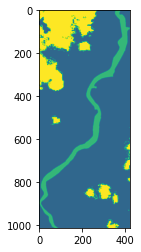

In [6]:
fig, ax = plt.subplots()

rasterio_plot(gt, vmin=0, vmax=3)

plt.show()


In this cell, we want to run the previous inputs through the GT script. 

We are generating the new ground truth.

In [11]:

demo_floodmap_meta = "worldfloods/public/test/meta/EMSR286_09ITUANGOSOUTH_DEL_MONIT02_v1_observed_event_a.json"


storage_client = storage.Client()
bucket = storage_client.get_bucket("ml4floods")
blob = bucket.blob(demo_floodmap_meta)

# Download the contents of the blob as a string and then parse it using json.loads() method
floodmap_meta = json.loads(blob.download_as_string(client=None))


In [12]:
%%time

# Run it through the GT script
gt_binary, gt_meta_binary = generate_water_cloud_binary_gt(
    demo_s2_image_path, floodmap_gdf, floodmap_meta,
)

cloud_channel, water_channel = 0, 1

Number cloudgt invalids: 0
Number watergt invalids: 0
CPU times: user 18.3 s, sys: 44.4 ms, total: 18.4 s
Wall time: 5.05 s


#### Demo Image

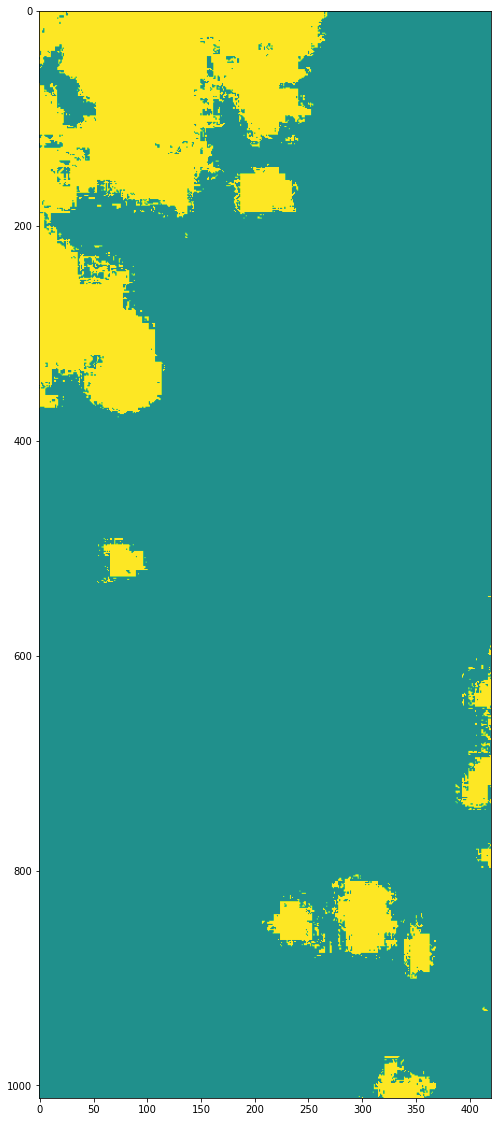

In [18]:

fig, ax = plt.subplots(figsize=(30,20))

rasterio_plot(gt_binary[cloud_channel], vmin=0, vmax=2)

plt.show()

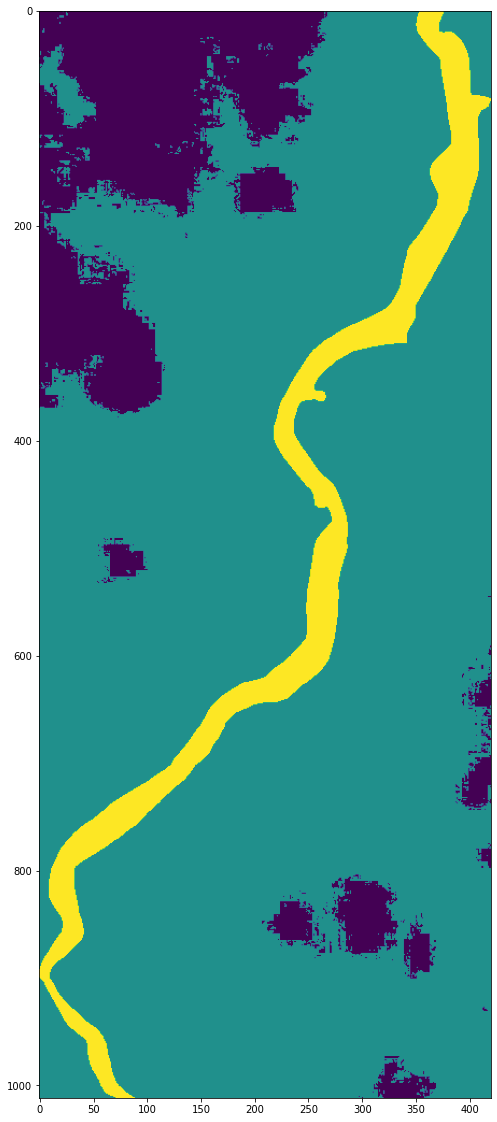

In [19]:

fig, ax = plt.subplots(figsize=(30,20))


rasterio_plot(gt_binary[water_channel], vmin=0, vmax=2)

plt.show()